In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pystan
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import collections
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
%matplotlib inline

In [2]:
tourney_results = pd.read_csv('../input/Stage2WDataFiles/WNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('../input/Stage2WDataFiles/WNCAATourneySeeds.csv')
regular_results = pd.read_csv('../input/Stage2WDataFiles/WRegularSeasonDetailedResults.csv')


In [3]:
all(regular_results.columns == tourney_results.columns)

True

In [4]:
regular_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [5]:
#反転用
regular_results_swap = regular_results[[
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

In [6]:
regular_results_swap.loc[regular_results['WLoc'] == 'H', 'WLoc'] = 'A'
regular_results_swap.loc[regular_results['WLoc'] == 'A', 'WLoc'] = 'H'
regular_results.columns.values[6] = 'location'
regular_results_swap.columns.values[6] = 'location'

In [7]:
regular_results.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(regular_results.columns)]
regular_results_swap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(regular_results.columns)]

In [8]:
regular_data = pd.concat([regular_results, regular_results_swap]).sort_index().reset_index(drop = True)

In [9]:
#ここから実行すればOK

In [10]:
tourney_results = pd.read_csv('../input/Stage2WDataFiles/WNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('../input/Stage2WDataFiles/WNCAATourneySeeds.csv')
regular_results = pd.read_csv('../input/Stage2WDataFiles/WRegularSeasonDetailedResults.csv')

def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output


In [11]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [12]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [13]:
#シーズンデータ
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]

In [14]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [15]:
#トーナメントデータ
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [16]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(5638, 5)

In [17]:
#直近データ
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [18]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [19]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [20]:
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                        team_quality(2019)]).reset_index(drop=True)

/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/statsmodels/genmod/families/links.py:167: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: divide by zero enco

In [21]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [22]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [23]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head()

,Season,Seed,TeamID,seed
0,1998,W01,3330,1
1,1998,W02,3163,2
2,1998,W03,3112,3
3,1998,W04,3301,4
4,1998,W05,3272,5


In [24]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [25]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [26]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

In [27]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    1134.0000
mean        0.0000
std        21.6625
min       -89.0000
25%       -14.0000
50%         0.0000
75%        14.0000
max        89.0000
dtype: float64

In [29]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

len(features)

45

In [30]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [31]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [32]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [33]:
xgb_cv = []
repeat_cv = 5 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:16.6796+0.188203	test-mae:16.6908+0.730334
[50]	train-mae:10.2332+0.102474	test-mae:10.932+0.512839
[100]	train-mae:9.36586+0.0668116	test-mae:10.5783+0.478979
[150]	train-mae:8.83031+0.0627163	test-mae:10.5194+0.430456
Fold repeater 1
[0]	train-mae:16.6844+0.171444	test-mae:16.7059+0.685815
[50]	train-mae:10.2061+0.175866	test-mae:10.8912+0.701457
[100]	train-mae:9.36372+0.159416	test-mae:10.5781+0.597611
[150]	train-mae:8.84078+0.143025	test-mae:10.5384+0.562425
Fold repeater 2
[0]	train-mae:16.6769+0.170657	test-mae:16.6921+0.794217
[50]	train-mae:10.2229+0.0919208	test-mae:10.8559+0.39943
[100]	train-mae:9.38152+0.109655	test-mae:10.5395+0.427792
[150]	train-mae:8.85665+0.120272	test-mae:10.499+0.492611
Fold repeater 3
[0]	train-mae:16.6815+0.12491	test-mae:16.6974+0.591736
[50]	train-mae:10.2447+0.114123	test-mae:10.8451+0.549502
[100]	train-mae:9.36485+0.0959966	test-mae:10.512+0.572909
[150]	train-mae:8.83017+0.0940763	test-mae:10.4227+0.581639
[200

In [34]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([166, 135, 154, 214, 179],
 [10.5109724, 10.5198696, 10.4893214, 10.390766000000001, 10.4280468])

In [35]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4


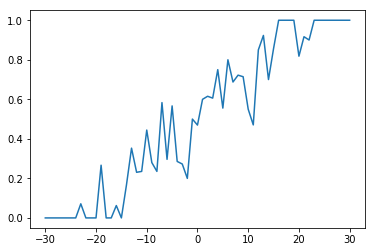

In [36]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [37]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.42973634187317944
logloss of cvsplit 1: 0.42727232145247046
logloss of cvsplit 2: 0.4282244129537172
logloss of cvsplit 3: 0.4237322862393597
logloss of cvsplit 4: 0.42655229281591445


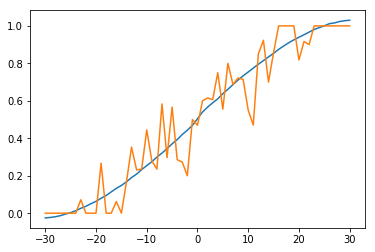

In [38]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [39]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.43399128403764997
adjusted logloss of cvsplit 1: 0.43084410063925244
adjusted logloss of cvsplit 2: 0.43225921462411865
adjusted logloss of cvsplit 3: 0.42821632911759105
adjusted logloss of cvsplit 4: 0.4301654421425327


In [40]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    """
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    """
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.43399128403764997
adjusted logloss of cvsplit 1: 0.43084410063925244
adjusted logloss of cvsplit 2: 0.43225921462411865
adjusted logloss of cvsplit 3: 0.42821632911759105
adjusted logloss of cvsplit 4: 0.4301654421425327


season
2010    0.420519
2011    0.385410
2012    0.422050
2013    0.427833
2014    0.416602
2015    0.365804
2016    0.514054
2017    0.479138
2018    0.448447
dtype: float64

In [49]:
#submission
sub = pd.read_csv('../input/WSampleSubmissionStage2.csv')
sub["Season"] = 2019
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'],how="left")
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'],how="left")
sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'],how="left")
sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'],how="left")
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'],how="left")
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'],how="left")
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'],how="left")
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'],how="left")
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

In [54]:
sub[sub["T1_quality"] != sub["T1_quality"]] #3126のT1_qualityがない？

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
363,2019_3126_3129,0.5,2019,3126,3129,21.62069,57.310345,4.827586,16.137931,12.344828,10.793103,16.0,7.586207,17.586207,22.172414,60.241379,4.965517,17.862069,13.137931,11.827586,16.206897,7.862069,3.896552,1.413793,27.366667,62.733333,7.833333,22.733333,12.100000,16.000000,14.233333,8.533333,16.866667,23.666667,56.433333,5.233333,15.933333,10.333333,11.666667,18.333333,6.600000,2.666667,8.766667,NaN,3.993956e+00,16,13,1.0,1.000000,3
364,2019_3126_3137,0.5,2019,3126,3137,21.62069,57.310345,4.827586,16.137931,12.344828,10.793103,16.0,7.586207,17.586207,22.172414,60.241379,4.965517,17.862069,13.137931,11.827586,16.206897,7.862069,3.896552,1.413793,25.848485,56.181818,8.333333,22.030303,9.515152,15.606061,14.757576,9.121212,18.363636,20.545455,56.303030,5.333333,17.787879,11.242424,11.424242,17.181818,6.484848,2.242424,15.121212,NaN,6.753832e-01,16,12,1.0,1.000000,4
365,2019_3126_3138,0.5,2019,3126,3138,21.62069,57.310345,4.827586,16.137931,12.344828,10.793103,16.0,7.586207,17.586207,22.172414,60.241379,4.965517,17.862069,13.137931,11.827586,16.206897,7.862069,3.896552,1.413793,26.250000,63.500000,7.031250,22.437500,14.625000,14.406250,15.031250,9.750000,18.843750,23.125000,58.500000,6.906250,22.375000,11.781250,14.500000,18.625000,6.218750,2.343750,9.500000,NaN,1.379105e+17,16,10,1.0,0.800000,6
366,2019_3126_3140,0.5,2019,3126,3140,21.62069,57.310345,4.827586,16.137931,12.344828,10.793103,16.0,7.586207,17.586207,22.172414,60.241379,4.965517,17.862069,13.137931,11.827586,16.206897,7.862069,3.896552,1.413793,25.483871,59.580645,6.967742,20.193548,11.548387,15.419355,13.806452,8.032258,16.451613,22.000000,59.258065,6.870968,21.645161,12.935484,13.483871,15.322581,7.258065,2.677419,6.451613,NaN,8.401066e+17,16,7,1.0,1.000000,9
367,2019_3126_3141,0.5,2019,3126,3141,21.62069,57.310345,4.827586,16.137931,12.344828,10.793103,16.0,7.586207,17.586207,22.172414,60.241379,4.965517,17.862069,13.137931,11.827586,16.206897,7.862069,3.896552,1.413793,29.687500,62.125000,9.125000,23.750000,12.031250,16.968750,13.812500,7.187500,14.750000,24.406250,61.718750,6.343750,20.000000,10.437500,11.031250,13.250000,6.781250,2.343750,14.687500,NaN,2.070032e+17,16,8,1.0,0.750000,8
368,2019_3126_3143,0.5,2019,3126,3143,21.62069,57.310345,4.827586,16.137931,12.344828,10.793103,16.0,7.586207,17.586207,22.172414,60.241379,4.965517,17.862069,13.137931,11.827586,16.206897,7.862069,3.896552,1.413793,26.677419,60.387097,7.193548,20.387097,12.516129,15.483871,13.290323,4.419355,15.096774,26.096774,61.225806,6.548387,18.677419,9.838710,13.354839,10.677419,5.677419,2.677419,3.483871,NaN,1.061106e+17,16,8,1.0,0.500000,8
369,2019_3126_3155,0.5,2019,3126,3155,21.62069,57.310345,4.827586,16.137931,12.344828,10.793103,16.0,7.586207,17.586207,22.172414,60.241379,4.965517,17.862069,13.137931,11.827586,16.206897,7.862069,3.896552,1.413793,26.161290,62.064516,3.806452,10.870968,14.096774,13.032258,19.870968,11.483871,17.838710,24.387097,61.870968,7.064516,22.935484,14.032258,13.612903,20.903226,9.548387,4.290323,2.612903,NaN,8.397477e+16,16,9,1.0,0.500000,7
370,2019_3126_3163,0.5,2019,3126,3163,21.62069,57.310345,4.827586,16.137931,12.344828,10.793103,16.0,7.586207,17.586207,22.172414,60.241379,4.965517,17.862069,13.137931,11.827586,16.206897,7.862069,3.896552,1.413793,31.000000,62.

In [55]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [56]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4


In [57]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
"""
sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0
"""
sub[['ID','Pred']].to_csv("../submit/raddar_base.csv", index = None)